In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
# --------------------------------------
# Cargar y Preparar el Conjunto de Datos
# --------------------------------------
# Cargar el dataset Wholesale Customers desde el archivo CSV
# Ajusta la ruta si el archivo está en otra ubicación
data = pd.read_csv("Wholesale customers data.csv")
# Seleccionar todas las características numéricas (excluyendo Channel y Region, si están presentes)
X = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].values

# Escalar los datos para normalizar las características (importante para DBSCAN y GMM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducir a 2D con PCA para compatibilidad con las visualizaciones
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)


DBSCAN (eps=0.5) etiquetas: [-1  0]
DBSCAN (eps=1.0) etiquetas: [-1  0]


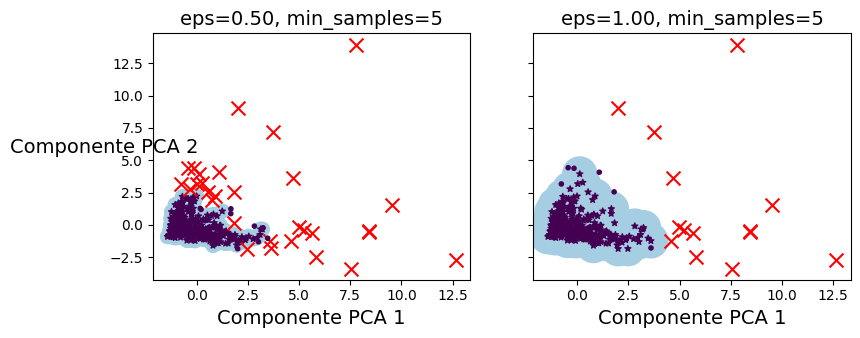

In [3]:
# --------------------------------------
# Clustering con DBSCAN
# --------------------------------------
# Aplicar DBSCAN con dos valores de eps para detectar clusters y ruido
# eps ajustado para datos escalados y reducidos con PCA
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps pequeño para clusters más definidos
dbscan.fit(X_2d)
print("DBSCAN (eps=0.5) etiquetas:", np.unique(dbscan.labels_))

dbscan2 = DBSCAN(eps=1.0, min_samples=5)  # eps más grande para clusters más amplios
dbscan2.fit(X_2d)
print("DBSCAN (eps=1.0) etiquetas:", np.unique(dbscan2.labels_))

# Función para graficar resultados de DBSCAN (sin cambios, solo etiquetas actualizadas)
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("Componente PCA 1", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("Componente PCA 2", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}", fontsize=14)

# Graficar resultados de DBSCAN
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_dbscan(dbscan, X_2d, size=100)
plt.subplot(122)
plot_dbscan(dbscan2, X_2d, size=600, show_ylabels=False)
plt.show()


Predicciones KNN para nuevos puntos: [0 0 0 0]
Probabilidades de predicción KNN: [[1.]
 [1.]
 [1.]
 [1.]]


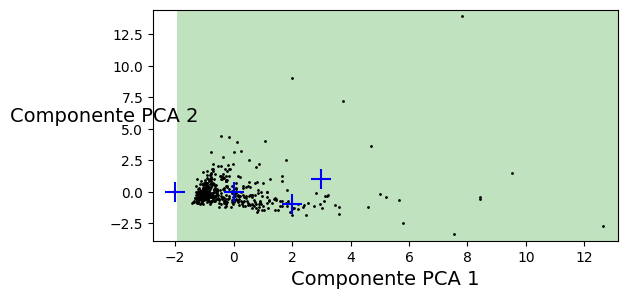

In [4]:
# --------------------------------------
# Clasificador KNN para Puntos de DBSCAN
# --------------------------------------
# Entrenar KNN con los puntos centrales del segundo modelo DBSCAN
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

# Predecir clusters para nuevos puntos (en el espacio PCA)
X_new = np.array([[-2, 0], [0, 0], [2, -1], [3, 1]])  # Ejemplos en espacio PCA
y_pred = knn.predict(X_new)
y_proba = knn.predict_proba(X_new)
print("Predicciones KNN para nuevos puntos:", y_pred)
print("Probabilidades de predicción KNN:", y_proba)

# Función para graficar fronteras de decisión de KNN
def plot_decision_boundaries(clusterer, X, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.5
    maxs = X.max(axis=0) + 0.5
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
                         np.linspace(mins[1], maxs[1], 1000))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Paired")
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    if show_centroids:
        plt.scatter(clusterer.components_[:, 0], clusterer.components_[:, 1],
                    c='r', marker='*', s=200, linewidths=2, zorder=10)
    if show_xlabels:
        plt.xlabel("Componente PCA 1", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("Componente PCA 2", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# Graficar fronteras de decisión con nuevos puntos
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X_2d, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [ ]:
# --------------------------------------
# Modelo de Mezcla de Gaussianas (GMM)
# --------------------------------------
# Ajustar GMM con 3 componentes (basado en posibles segmentos de clientes)
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_2d)

# Funciones para graficar GMM (sin cambios, solo etiquetas actualizadas)
def plot_centroids(centroids, weights, circle_color='w', cross_color='k'):
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30*weights*1000,
                linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50,
                linewidths=50, color=cross_color, zorder=11, alpha=1.0)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.5
    maxs = X.max(axis=0) + 0.5
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("Componente PCA 1", fontsize=14)
    if show_ylabels:
        plt.ylabel("Componente PCA 2", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# Graficar resultados de GMM
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_2d)
plt.show()

# Imprimir parámetros de GMM
print("Pesos GMM:", gm.weights_)
print("Medias GMM:", gm.means_)
print("Covarianzas GMM:", gm.covariances_)

# Predecir clusters y detectar anomalías
y_pred_gm = gm.predict(X_2d)
print("Predicciones GMM:", np.unique(y_pred_gm, return_counts=True))
densities = gm.score_samples(X_2d)
density_threshold = np.percentile(densities, 4)
anomalies = X_2d[densities < density_threshold]

# Graficar GMM con anomalías
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_2d)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.show()

D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.p

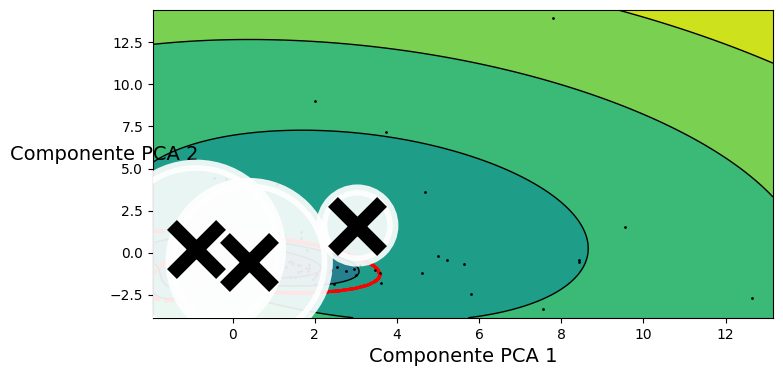

Pesos GMM: [0.42186012 0.49086228 0.08727761]
Medias GMM: [[ 0.40398472 -0.54304281]
 [-0.88691013  0.18139025]
 [ 3.03543702  1.60465522]]
Covarianzas GMM: [[[ 1.01567584 -0.22478577]
  [-0.22478577  0.30851965]]

 [[ 0.08113098  0.12886033]
  [ 0.12886033  0.55351541]]

 [[10.51295986 -2.54386481]
  [-2.54386481 10.71804203]]]
Predicciones GMM: (array([0, 1, 2]), array([165, 240,  35]))


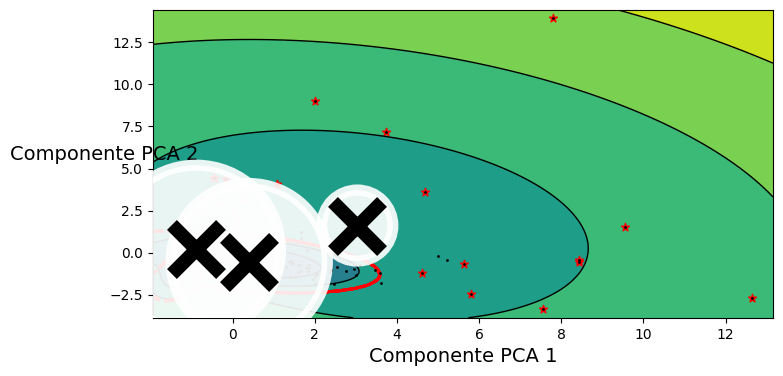

D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.p

Pesos BGM: [0.16 0.3  0.   0.47 0.01 0.04 0.02 0.   0.   0.  ]


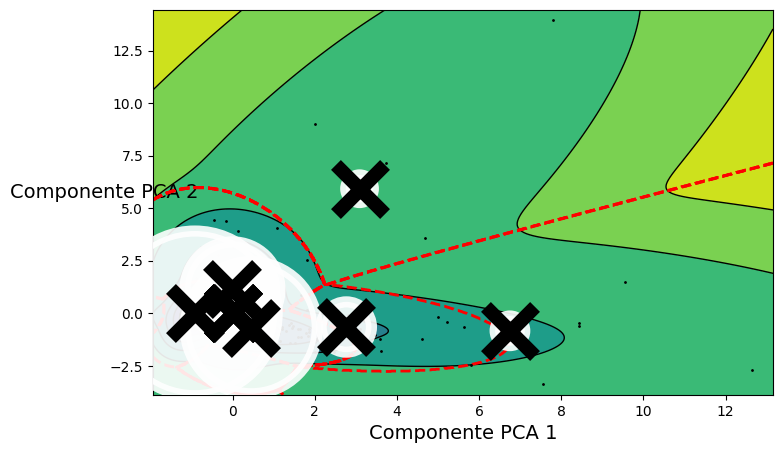

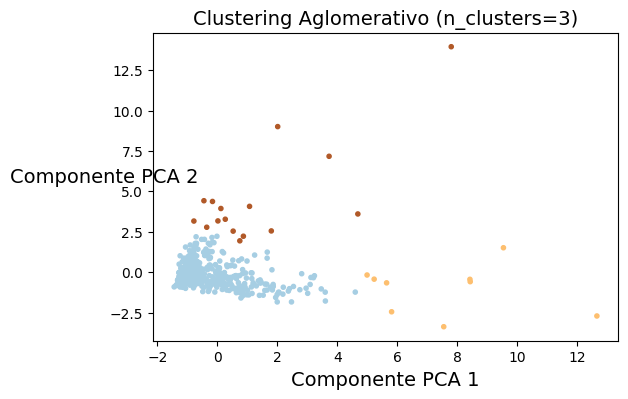

Etiquetas Clustering Aglomerativo: (array([0, 1, 2]), array([415,   9,  16]))


In [5]:



# --------------------------------------
# Mezcla de Gaussianas Bayesiana (BGM)
# --------------------------------------
# Ajustar BGM con hasta 10 componentes (selecciona automáticamente los relevantes)
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_2d)
print("Pesos BGM:", np.round(bgm.weights_, 2))

# Graficar resultados de BGM
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X_2d)
plt.show()

# --------------------------------------
# Nuevo Modelo: Clustering Aglomerativo
# --------------------------------------
# Aplicar clustering aglomerativo con 3 clusters (usando enlace 'ward')
agg_clust = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg_clust.fit_predict(X_2d)

# Graficar resultados de clustering aglomerativo
plt.figure(figsize=(6, 4))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=agg_labels, cmap="Paired", marker='.')
plt.xlabel("Componente PCA 1", fontsize=14)
plt.ylabel("Componente PCA 2", fontsize=14, rotation=0)
plt.title("Clustering Aglomerativo (n_clusters=3)", fontsize=14)
plt.show()

print("Etiquetas Clustering Aglomerativo:", np.unique(agg_labels, return_counts=True))